# ``Module`` System Protocol

The module system is the foundation for building neural networks in BrainState. It provides a clean, object-oriented interface for organizing stateful computations.

In this tutorial, you will learn:

- 🏗️ The `Module` base class and its role
- 🔨 How to create custom modules
- 🧩 Module composition and nesting
- 🎯 Parameter management and initialization
- 📦 Working with module hierarchies

## Why Modules?

Modules (via `brainstate.nn.Module`) provide:

✅ **Automatic state management** - States are tracked automatically  
✅ **Clean abstractions** - Encapsulate related computations  
✅ **Reusability** - Build once, use everywhere  
✅ **Composability** - Combine simple modules into complex systems

In [15]:
import brainstate
import jax.numpy as jnp
import matplotlib.pyplot as plt

## 1. The Module Base Class

`brainstate.nn.Module` is the base class for all modules in BrainState. It provides:

- Automatic registration of child modules
- State collection and management
- Pretty printing and inspection
- Integration with JAX transformations

### Creating Your First Module

The simplest module inherits from `Module` and implements `update()`:

In [16]:
class SimpleModule(brainstate.nn.Module):
    """A minimal module that adds a constant."""
    
    def __init__(self, constant=1.0):
        super().__init__()  # Always call parent __init__
        self.constant = constant
    
    def update(self, x):
        return x + self.constant

# Create and use the module
module = SimpleModule(constant=5.0)
result = module(jnp.array([1.0, 2.0, 3.0]))

print("Input:", jnp.array([1.0, 2.0, 3.0]))
print("Output:", result)
print("\nModule:")
print(module)

Input: [1. 2. 3.]
Output: [6. 7. 8.]

Module:
SimpleModule(
  constant=5.0
)


### Adding States to Modules

Modules become powerful when they contain states:

In [17]:
class Counter(brainstate.nn.Module):
    """A module that counts how many times it's called."""
    
    def __init__(self):
        super().__init__()
        # Create a state to track the count
        self.count = brainstate.ShortTermState(jnp.array(0))
    
    def update(self, x):
        # Increment counter
        self.count.value = self.count.value + 1
        # Return input with count
        return x * self.count.value

# Test the counter
counter = Counter()
print("Initial count:", counter.count.value)

for i in range(5):
    result = counter(jnp.array(10.0))
    print(f"Call {i+1}: count={counter.count.value}, result={result}")

Initial count: 0
Call 1: count=1, result=10.0
Call 2: count=2, result=20.0
Call 3: count=3, result=30.0
Call 4: count=4, result=40.0
Call 5: count=5, result=50.0


## 2. Creating Custom Modules

Let's build a complete linear layer from scratch to understand module design:

### Example: Custom Linear Layer

In [18]:
class Linear(brainstate.nn.Module):
    """A linear transformation: y = W @ x + b"""
    
    def __init__(self, in_features, out_features, use_bias=True):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        
        # Initialize weight with Xavier/Glorot initialization
        std = jnp.sqrt(2.0 / (in_features + out_features))
        self.weight = brainstate.ParamState(
            brainstate.random.randn(in_features, out_features) * std
        )
        
        # Initialize bias to zero
        if use_bias:
            self.bias = brainstate.ParamState(jnp.zeros(out_features))
    
    def update(self, x):
        """Forward pass.
        
        Args:
            x: Input tensor of shape (..., in_features)
            
        Returns:
            Output tensor of shape (..., out_features)
        """
        out = x @ self.weight.value
        if self.use_bias:
            out = out + self.bias.value
        return out
    
    def __repr__(self):
        return f"Linear(in_features={self.in_features}, out_features={self.out_features}, use_bias={self.use_bias})"

# Create and test the linear layer
brainstate.random.seed(42)
linear = Linear(in_features=5, out_features=3)

# Forward pass
x = jnp.ones(5)
y = linear(x)

print("Module:")
print(linear)
print(f"\nWeight shape: {linear.weight.value.shape}")
print(f"Bias shape: {linear.bias.value.shape}")
print(f"\nInput shape: {x.shape}")
print(f"Output shape: {y.shape}")
print(f"Output: {y}")

Module:
Linear(in_features=5, out_features=3, use_bias=True)

Weight shape: (5, 3)
Bias shape: (3,)

Input shape: (5,)
Output shape: (3,)
Output: [ 0.3793956  -0.9351347  -0.94997764]


### Example: Custom Activation Module

Activation: LeakyReLU(negative_slope=0.1)
Input:  [-2. -1.  0.  1.  2.]
Output: [-0.2 -0.1  0.   1.   2. ]


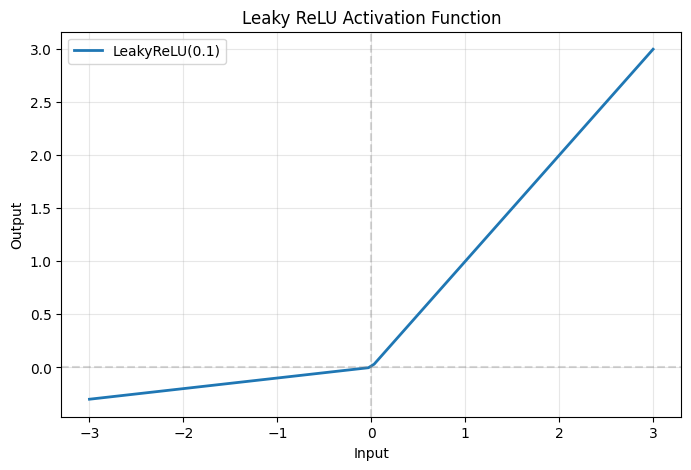

In [19]:
class LeakyReLU(brainstate.nn.Module):
    """Leaky ReLU activation: y = max(alpha * x, x)"""
    
    def __init__(self, negative_slope=0.01):
        super().__init__()
        self.negative_slope = negative_slope
    
    def update(self, x):
        return jnp.where(x > 0, x, self.negative_slope * x)
    
    def __repr__(self):
        return f"LeakyReLU(negative_slope={self.negative_slope})"

# Test the activation
activation = LeakyReLU(negative_slope=0.1)
x = jnp.array([-2.0, -1.0, 0.0, 1.0, 2.0])
y = activation(x)

print("Activation:", activation)
print(f"Input:  {x}")
print(f"Output: {y}")

# Visualize
x_plot = jnp.linspace(-3, 3, 100)
y_plot = activation(x_plot)

plt.figure(figsize=(8, 5))
plt.plot(x_plot, y_plot, linewidth=2, label='LeakyReLU(0.1)')
plt.axhline(0, color='gray', linestyle='--', alpha=0.3)
plt.axvline(0, color='gray', linestyle='--', alpha=0.3)
plt.grid(alpha=0.3)
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Leaky ReLU Activation Function')
plt.legend()
plt.show()

## 3. Module Composition and Nesting

The real power of modules comes from composing them into larger networks.

### Sequential Composition

Build a network by stacking layers sequentially:

In [20]:
class MLP(brainstate.nn.Module):
    """Multi-layer perceptron with customizable architecture."""
    
    def __init__(self, layer_sizes, activation='relu'):
        super().__init__()
        
        self.layers = []
        
        # Create layers
        for i in range(len(layer_sizes) - 1):
            # Add linear layer
            layer = Linear(layer_sizes[i], layer_sizes[i+1])
            setattr(self, f'layer_{i}', layer)  # Register as attribute
            self.layers.append(layer)
            
            # Add activation (except for last layer)
            if i < len(layer_sizes) - 2:
                if activation == 'relu':
                    act = LeakyReLU(negative_slope=0.0)  # Standard ReLU
                else:
                    act = LeakyReLU(negative_slope=0.01)
                setattr(self, f'activation_{i}', act)
                self.layers.append(act)
    
    def update(self, x):
        """Forward pass through all layers."""
        for layer in self.layers:
            x = layer(x)
        return x

# Create a 3-layer MLP
brainstate.random.seed(0)
mlp = MLP(layer_sizes=[10, 64, 32, 5])

# Forward pass
x = brainstate.random.randn(10)
y = mlp(x)

print("MLP Architecture:")
print(mlp)
print(f"\nInput shape: {x.shape}")
print(f"Output shape: {y.shape}")
print(f"Output: {y}")

MLP Architecture:
MLP(
  layers=[
    Linear(in_features=10, out_features=64, use_bias=True),
    LeakyReLU(negative_slope=0.0),
    Linear(in_features=64, out_features=32, use_bias=True),
    LeakyReLU(negative_slope=0.0),
    Linear(in_features=32, out_features=5, use_bias=True)
  ],
  layer_0=Linear(in_features=10, out_features=64, use_bias=True),
  activation_0=LeakyReLU(negative_slope=0.0),
  layer_1=Linear(in_features=64, out_features=32, use_bias=True),
  activation_1=LeakyReLU(negative_slope=0.0),
  layer_2=Linear(in_features=32, out_features=5, use_bias=True)
)

Input shape: (10,)
Output shape: (5,)
Output: [-0.49218872  0.5558434  -0.6296929   0.25295696  0.37388656]


### Residual Connections

Implement skip connections for deeper networks:

In [21]:
class ResidualBlock(brainstate.nn.Module):
    """Residual block: y = F(x) + x"""
    
    def __init__(self, dim):
        super().__init__()
        
        # Two linear layers with activation in between
        self.linear1 = Linear(dim, dim)
        self.activation = LeakyReLU(0.0)
        self.linear2 = Linear(dim, dim)
    
    def update(self, x):
        # Compute residual
        residual = x
        
        # Forward through layers
        out = self.linear1(x)
        out = self.activation(out)
        out = self.linear2(out)
        
        # Add residual
        return out + residual

class ResNet(brainstate.nn.Module):
    """Simple ResNet with multiple residual blocks."""
    
    def __init__(self, input_dim, hidden_dim, output_dim, n_blocks=3):
        super().__init__()
        
        # Input projection
        self.input_proj = Linear(input_dim, hidden_dim)
        
        # Residual blocks
        self.blocks = []
        for i in range(n_blocks):
            block = ResidualBlock(hidden_dim)
            setattr(self, f'block_{i}', block)
            self.blocks.append(block)
        
        # Output projection
        self.output_proj = Linear(hidden_dim, output_dim)
    
    def update(self, x):
        # Project to hidden dimension
        x = self.input_proj(x)
        
        # Pass through residual blocks
        for block in self.blocks:
            x = block(x)
        
        # Project to output
        x = self.output_proj(x)
        return x

# Create ResNet
brainstate.random.seed(0)
resnet = ResNet(input_dim=10, hidden_dim=32, output_dim=5, n_blocks=3)

# Forward pass
x = brainstate.random.randn(10)
y = resnet(x)

print("ResNet:")
print(resnet)
print(f"\nOutput shape: {y.shape}")

ResNet:
ResNet(
  input_proj=Linear(in_features=10, out_features=32, use_bias=True),
  blocks=[
    ResidualBlock(
      linear1=Linear(in_features=32, out_features=32, use_bias=True),
      activation=LeakyReLU(negative_slope=0.0),
      linear2=Linear(in_features=32, out_features=32, use_bias=True)
    ),
    ResidualBlock(
      linear1=Linear(in_features=32, out_features=32, use_bias=True),
      activation=LeakyReLU(negative_slope=0.0),
      linear2=Linear(in_features=32, out_features=32, use_bias=True)
    ),
    ResidualBlock(
      linear1=Linear(in_features=32, out_features=32, use_bias=True),
      activation=LeakyReLU(negative_slope=0.0),
      linear2=Linear(in_features=32, out_features=32, use_bias=True)
    )
  ],
  block_0=ResidualBlock(...),
  block_1=ResidualBlock(...),
  block_2=ResidualBlock(...),
  output_proj=Linear(in_features=32, out_features=5, use_bias=True)
)

Output shape: (5,)


## 4. Automatic Input/Output Size Inference

One of BrainState's most powerful features is **automatic input/output size inference**. Every `brainstate.nn.Module` instance has `in_size` and `out_size` properties that track the shape of data flowing through the module (excluding the batch dimension).

### Key Concepts

✅ **`in_size`**: Input shape without batch dimension  
✅ **`out_size`**: Output shape without batch dimension (automatically inferred)  
✅ **Automatic propagation**: When `in_size` is known, `out_size` is computed automatically  
✅ **Sequential composition**: Output size of one layer becomes input size of next layer

This mechanism eliminates the need to manually calculate dimensions through network layers, making it much easier to build complex architectures.

### Example 1: Basic Size Inference

In [22]:
# Create a linear layer with explicit in_size and out_size
layer = brainstate.nn.Linear(in_size=(10,), out_size=(5,))

print("Layer:", layer)
print(f"Input size:  {layer.in_size}")
print(f"Output size: {layer.out_size}")

# Forward pass with batch dimension
x = brainstate.random.randn(32, 10)  # (batch_size, in_features)
y = layer(x)

print(f"\nInput shape:  {x.shape}  (batch_size=32, in_features=10)")
print(f"Output shape: {y.shape}  (batch_size=32, out_features=5)")
print("\nNote: in_size and out_size DO NOT include the batch dimension!")

Layer: Linear(
  in_size=(10,),
  out_size=(5,),
  w_mask=None,
  weight=ParamState(
    value={
      'bias': ShapedArray(float32[5]),
      'weight': ShapedArray(float32[10,5])
    }
  )
)
Input size:  (10,)
Output size: (5,)

Input shape:  (32, 10)  (batch_size=32, in_features=10)
Output shape: (32, 5)  (batch_size=32, out_features=5)

Note: in_size and out_size DO NOT include the batch dimension!


### Example 2: Size Inference with Convolution

Convolution layers automatically compute output spatial dimensions based on:
- Input spatial size
- Kernel size
- Stride
- Padding mode

In [23]:
# Create a 2D convolution layer
conv = brainstate.nn.Conv2d(
    in_size=(28, 28, 3),      # (height, width, channels)
    out_channels=32,
    kernel_size=3,
    stride=1,
    padding='SAME'
)

print("Conv2d Layer:")
print(f"  in_size:  {conv.in_size}")
print(f"  out_size: {conv.out_size}")
print(f"\n  Input:  (H, W, C) = {conv.in_size}")
print(f"  Output: (H', W', C') = {conv.out_size}")
print("\nWith 'SAME' padding and stride=1, spatial dimensions are preserved!")

# Test with different padding
conv_valid = brainstate.nn.Conv2d(
    in_size=(28, 28, 3),
    out_channels=32,
    kernel_size=3,
    stride=2,
    padding='VALID'
)

print(f"\nWith 'VALID' padding and stride=2:")
print(f"  in_size:  {conv_valid.in_size}")
print(f"  out_size: {conv_valid.out_size}")
print("  Spatial dimensions are reduced!")

Conv2d Layer:
  in_size:  (28, 28, 3)
  out_size: (28, 28, 32)

  Input:  (H, W, C) = (28, 28, 3)
  Output: (H', W', C') = (28, 28, 32)

With 'SAME' padding and stride=1, spatial dimensions are preserved!

With 'VALID' padding and stride=2:
  in_size:  (28, 28, 3)
  out_size: (13, 13, 32)
  Spatial dimensions are reduced!


### Example 3: Size Inference with Pooling and Flatten

Pooling layers reduce spatial dimensions, and Flatten layers convert multi-dimensional tensors to 1D vectors. BrainState tracks all these transformations automatically.

In [24]:
# MaxPool reduces spatial dimensions
pool = brainstate.nn.MaxPool2d(
    in_size=(28, 28, 32),
    kernel_size=(2, 2),
    stride=(2, 2),
    channel_axis=-1
)

print("MaxPool2d Layer:")
print(f"  in_size:  {pool.in_size}  (H=28, W=28, C=32)")
print(f"  out_size: {pool.out_size}  (H=14, W=14, C=32)")
print("  Spatial dimensions reduced by 2x!")

# Flatten converts to 1D
flatten = brainstate.nn.Flatten(in_size=(14, 14, 32))

print(f"\nFlatten Layer:")
print(f"  in_size:  {flatten.in_size}  (3D tensor)")
print(f"  out_size: {flatten.out_size}  (1D vector)")
print(f"  Total elements: {14 * 14 * 32} = {flatten.out_size[0]}")

MaxPool2d Layer:
  in_size:  (28, 28, 32)  (H=28, W=28, C=32)
  out_size: (14, 14, 32)  (H=14, W=14, C=32)
  Spatial dimensions reduced by 2x!

Flatten Layer:
  in_size:  (14, 14, 32)  (3D tensor)
  out_size: (6272,)  (1D vector)
  Total elements: 6272 = 6272


## 5. Sequential Composition and Deep Networks

`brainstate.nn.Sequential` is a powerful container that chains multiple modules together. It automatically propagates `out_size` from one layer to the `in_size` of the next layer, enabling effortless construction of deep networks.

### The `.desc()` Pattern

For layers that need to infer their `in_size` from the previous layer, BrainState provides the `.desc()` method, which creates a **layer descriptor** that will be instantiated when the input size becomes available.

```python
# Instead of:
brainstate.nn.Linear(in_size=(10,), out_size=(5,))

# Use descriptor in Sequential:
brainstate.nn.Linear.desc(out_size=5)  # in_size will be inferred!
```

### Example 1: Simple Sequential Network

In [25]:
# Build a simple MLP with Sequential
brainstate.random.seed(42)

mlp = brainstate.nn.Sequential(
    brainstate.nn.Linear((10,), (64,)),        # First layer needs explicit in_size
    brainstate.nn.ReLU(),                      # Element-wise, preserves shape
    brainstate.nn.Linear.desc(out_size=32),    # in_size inferred from previous layer
    brainstate.nn.ReLU(),
    brainstate.nn.Linear.desc(out_size=5)      # Final output layer
)

print("Sequential MLP:")
print(mlp)
print(f"\nInput size:  {mlp.in_size}")
print(f"Output size: {mlp.out_size}")

# Test forward pass
x = brainstate.random.randn(8, 10)  # batch of 8 samples
y = mlp(x)
print(f"\nForward pass:")
print(f"  Input:  {x.shape}")
print(f"  Output: {y.shape}")

Sequential MLP:
Sequential(
  in_size=(10,),
  out_size=(5,),
  layers=[
    Linear(
      in_size=(10,),
      out_size=(64,),
      w_mask=None,
      weight=ParamState(
        value={
          'bias': ShapedArray(float32[64]),
          'weight': ShapedArray(float32[10,64])
        }
      )
    ),
    ReLU(),
    Linear(
      in_size=(64,),
      out_size=(32,),
      w_mask=None,
      weight=ParamState(
        value={
          'bias': ShapedArray(float32[32]),
          'weight': ShapedArray(float32[64,32])
        }
      )
    ),
    ReLU(),
    Linear(
      in_size=(32,),
      out_size=(5,),
      w_mask=None,
      weight=ParamState(
        value={
          'bias': ShapedArray(float32[5]),
          'weight': ShapedArray(float32[32,5])
        }
      )
    )
  ]
)

Input size:  (10,)
Output size: (5,)

Forward pass:
  Input:  (8, 10)
  Output: (8, 5)


### Example 2: CNN Network with Automatic Size Propagation

Let's build a complete CNN for image classification, demonstrating how `in_size` and `out_size` propagate through convolutional, pooling, flattening, and fully-connected layers.

In [26]:
class CNNNet(brainstate.nn.Module):
    """Convolutional Neural Network for image classification."""
    
    def __init__(self, in_size):
        super().__init__()
        self.layer = brainstate.nn.Sequential(
            # Convolutional block 1
            brainstate.nn.Conv2d(in_size, out_channels=32, kernel_size=(3, 3), 
                               stride=(1, 1), padding='SAME'),
            brainstate.nn.ReLU(),
            brainstate.nn.MaxPool2d.desc(kernel_size=(2, 2), stride=(2, 2), channel_axis=-1),
            
            # Convolutional block 2
            brainstate.nn.Conv2d.desc(out_channels=64, kernel_size=(3, 3), 
                                    stride=(1, 1), padding='SAME'),
            brainstate.nn.ReLU(),
            brainstate.nn.MaxPool2d.desc(kernel_size=(2, 2), stride=(2, 2), channel_axis=-1),
            
            # Flatten and fully-connected layers
            brainstate.nn.Flatten.desc(),
            brainstate.nn.Linear.desc(out_size=1024),
            brainstate.nn.ReLU(),
            brainstate.nn.Linear.desc(out_size=512),
            brainstate.nn.ReLU(),
            brainstate.nn.Linear.desc(out_size=10)
        )

    def update(self, x):
        return self.layer(x)

# Create CNN with image size (28, 28, 3)
example_image = brainstate.random.normal(size=(28, 28, 3))
cnn = CNNNet(example_image.shape)

print("CNN Network Architecture:")
print(cnn)
print(f"\nNetwork input size:  {cnn.in_size}")
print(f"Network output size: {cnn.out_size}")

# Trace size transformations through the network
print("\n" + "="*60)
print("Size transformations through the network:")
print("="*60)
for i, layer in enumerate(cnn.layer.layers):
    if hasattr(layer, 'in_size') and hasattr(layer, 'out_size'):
        print(f"Layer {i:2d} ({layer.__class__.__name__:15s}): "
              f"{str(layer.in_size):20s} -> {str(layer.out_size):20s}")

CNN Network Architecture:
CNNNet(
  layer=Sequential(
    in_size=(28, 28, 3),
    out_size=(10,),
    layers=[
      Conv2d(
        in_size=(28, 28, 3),
        out_size=(28, 28, 32),
        channel_first=False,
        channels_last=True,
        in_channels=3,
        out_channels=32,
        stride=(1, 1),
        kernel_size=(3, 3),
        lhs_dilation=(1, 1),
        rhs_dilation=(1, 1),
        groups=1,
        dimension_numbers=ConvDimensionNumbers(lhs_spec=(0, 3, 1, 2), rhs_spec=(3, 2, 0, 1), out_spec=(0, 3, 1, 2)),
        padding=SAME,
        kernel_shape=(3, 3, 3, 32),
        w_mask=None,
        w_initializer=XavierNormal(
          scale=1.0,
          mode='fan_avg',
          in_axis=-2,
          out_axis=-1,
          distribution='truncated_normal',
          rng=RandomState([1825841970 3512247751]),
          unit=Unit(10.0^0)
        ),
        b_initializer=None,
        weight=ParamState(
          value={
            'weight': ShapedArray(float32[3,3,3,32]

### Example 3: Forward Pass Through CNN

Let's actually run a forward pass and see how data flows through the network.

In [27]:
# Create a batch of images
batch_size = 4
batch_images = brainstate.random.normal(size=(batch_size, 28, 28, 3))

print(f"Input batch shape: {batch_images.shape}")
print(f"  (batch_size, height, width, channels) = ({batch_size}, 28, 28, 3)")

# Forward pass
output = cnn(batch_images)

print(f"\nOutput shape: {output.shape}")
print(f"  (batch_size, num_classes) = ({batch_size}, 10)")
print(f"\nOutput logits for first sample:")
print(output[0])

Input batch shape: (4, 28, 28, 3)
  (batch_size, height, width, channels) = (4, 28, 28, 3)

Output shape: (4, 10)
  (batch_size, num_classes) = (4, 10)

Output logits for first sample:
[ 0.13889284  0.49220082 -0.6353385   0.36826375 -0.55741405 -0.22296685
  1.5445015   0.7295152   0.04205686 -0.02874903]


### Benefits of Automatic Size Inference

The automatic `in_size`/`out_size` inference system provides several key advantages:

1. **🎯 No manual dimension calculations**: You don't need to compute output sizes after each layer
2. **🔧 Easy architecture modifications**: Change one layer without updating all subsequent layers
3. **🐛 Early error detection**: Shape mismatches are caught at construction time
4. **📊 Built-in documentation**: Network architecture is self-documenting with size information
5. **🚀 Rapid prototyping**: Quickly experiment with different architectures

### Key Pattern: `.desc()` for Layer Descriptors

When building networks with `Sequential`, use the `.desc()` pattern for all layers except the first:

```python
brainstate.nn.Sequential(
    FirstLayer(in_size, ...),         # Explicit in_size
    SecondLayer.desc(...),            # in_size inferred
    ThirdLayer.desc(...),             # in_size inferred
    # ...
)
```

This pattern ensures that:
- The first layer knows the input size
- All subsequent layers automatically infer their input sizes
- The network construction is clean and maintainable

### Example 4: Complex Architecture with Mixed Layer Types

In [28]:
# Build a more complex network with different layer types
class ComplexNet(brainstate.nn.Module):
    """Complex network demonstrating various layer types."""
    
    def __init__(self, in_size):
        super().__init__()
        
        self.features = brainstate.nn.Sequential(
            # Initial conv block
            brainstate.nn.Conv2d(in_size, out_channels=16, kernel_size=3, padding='SAME'),
            brainstate.nn.ReLU(),
            
            # Strided conv (reduces spatial size)
            brainstate.nn.Conv2d.desc(out_channels=32, kernel_size=3, stride=2, padding='SAME'),
            brainstate.nn.ReLU(),
            
            # Another conv + pool
            brainstate.nn.Conv2d.desc(out_channels=64, kernel_size=3, padding='SAME'),
            brainstate.nn.ReLU(),
            brainstate.nn.MaxPool2d.desc(kernel_size=(2, 2), stride=(2, 2), channel_axis=-1),
        )
        
        self.classifier = brainstate.nn.Sequential(
            brainstate.nn.Flatten(in_size=self.features.out_size),
            brainstate.nn.Linear.desc(out_size=256),
            brainstate.nn.ReLU(),
            brainstate.nn.Linear.desc(out_size=10),
        )
    
    def update(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Create network
net = ComplexNet(in_size=(32, 32, 3))

print("Complex Network:")
print(f"Input size: {net.features.in_size}")
print(f"After features: {net.features.out_size}")
print(f"After flatten: {net.classifier.layers[0].out_size}")
print(f"Final output: {net.classifier.out_size}")

# Test
x = brainstate.random.randn(2, 32, 32, 3)
y = net(x)
print(f"\nForward pass: {x.shape} -> {y.shape}")

Complex Network:
Input size: (32, 32, 3)
After features: (8, 8, 64)
After flatten: (4096,)
Final output: (10,)

Forward pass: (2, 32, 32, 3) -> (2, 10)
